In [29]:
import glob
import os
import time
import math
import json
import random
from openslide import OpenSlide
from openslide.deepzoom import DeepZoomGenerator
import matplotlib.pyplot as plt
from PIL import ImageDraw
import pandas as pd
from matplotlib.patches import Ellipse
import numpy as np


%matplotlib inline

# Fir virtualenv autocompletion.
%config Completer.use_jedi = False

DATA_ROOT = '../data/'

In [2]:
def load_mrxs_files(data_dir):
    full_paths = glob.glob(data_dir + '*.mrxs')
    return [os.path.basename(file) for file in full_paths]

In [3]:
def load_annotations(mrxs_files):
    anns = []
    ann_files = [ file.replace('mrxs', 'json') for file in mrxs_files]
    for file in ann_files:
        with open(DATA_ROOT + file) as f:
            ann_json = json.load(f)
            anns.append(ann_json)
    return tuple(anns)

In [4]:
mrxs_files = load_mrxs_files(DATA_ROOT)
annotations = load_annotations(mrxs_files)
slides = []
for file in mrxs_files:
    slides.append(OpenSlide(DATA_ROOT + file))

## Slide object parameters

In [5]:
slide = slides[0]
print("Levels: {}".format(slide.level_count))
for idx, dimensions in enumerate(slide.level_dimensions):
    print("\tLVL {} - {:8d} X {} px".format(idx, dimensions[0], dimensions[1]))

Levels: 10
	LVL 0 -   177152 X 416768 px
	LVL 1 -    88576 X 208384 px
	LVL 2 -    44288 X 104192 px
	LVL 3 -    22144 X 52096 px
	LVL 4 -    11072 X 26048 px
	LVL 5 -     5536 X 13024 px
	LVL 6 -     2768 X 6512 px
	LVL 7 -     1384 X 3256 px
	LVL 8 -      692 X 1628 px
	LVL 9 -      346 X 814 px


## Annotations file example 

Selecting an annotation and displaying the annotated section in the middle of image.

In [6]:
annotations[0]['annotations']['1']

{'geometry': {'annotation_type': 'ELLIPSE',
  'origin_point': [0, 0],
  'points': [[123620, 194814], [123722, 194887]]},
 'id': '1',
 'label': 'annotation_1',
 'tree_view_config': {'display_pattern': '{label}',
  'decoration_attr': 'figure_graphics_view_config.color',
  'decoration_size': None},
 'text_graphics_view_config': {'display_pattern': '{label}\\n{stats[text]}\\n{filter_results[text]}',
  'hidden': False,
  'background_color': '#32cd32'},
 'figure_graphics_view_config': {'hidden': False, 'color': '#32cd32'},
 'stats': {'text': 'area: 88µ²',
  'area': 88,
  'area_px': 5986,
  'area_text': 'area: 88µ²',
  'length': None,
  'length_px': None,
  'length_text': None},
 'filter_id': None,
 'filter_level': None,
 'filter_results': None,
 'user_attrs': {'z_index': 'type 1', 'ROI': 'true', 'label_color 1': '1'}}

In [7]:
def show_annotated_section(annotation, slide, image_size=512, save=False, filename=None):
    """
        Shows a single annotation centred in the image.
        image_size - returned image size
    """
    ann_type = annotation['geometry']['annotation_type']

    if ann_type != 'ELLIPSE':
        raise NotImplementedError
        
    colors = {
        'label_color 1' : 'blue',
        'label_color 2' : 'green',
        'label_color 3' : 'red',
        'label_color 4' : 'yellow'
    }
       
    
    # Annotations are for ellipses that are defined by
    # two points of bounding boxes.
    ann_points = annotation['geometry']['points']
    x1, y1 = ann_points[0][0], ann_points[0][1]
    x2, y2 = ann_points[1][0], ann_points[1][1]
    
    # Locate the region so that the annotation first
    # coordinate is in the middle of the section.
    img = slide.read_region(
        location = (x1 - image_size//2, y1 - image_size//2),
        level = 0,
        size = (image_size, image_size)
    )
    

    # Ellipse starts from the middle of image.
    point1 = (image_size//2, image_size//2)
    # Ends where the second box is relative to the image.
    point2 = (image_size//2 + (x2 -x1), image_size//2 + (y2 -y1))
    # Pillow draws only if point1 < point2,
    # so that the point1 is upper left and point2 is lower right.
    if point1 > point2:
        #Swap
        point1, point2 = point2, point1
        
    # Color according to label.
    # White to check if there are missing labels.
    outline_color = 'white' 
    for key in annotation['user_attrs'].keys():
        if key in colors.keys():
            outline_color = colors[key]
 
    # Draw an ellipse over the image
    draw = ImageDraw.Draw(img)
    draw.ellipse(
        [
            point1,
            point2
        ],
        width=5,
        outline=outline_color
    )
    
    if save:
        if filename == None:
            filename = annotation['label'] + '.png'
        img.save('./samples/' + filename)
    else:
          display(img)

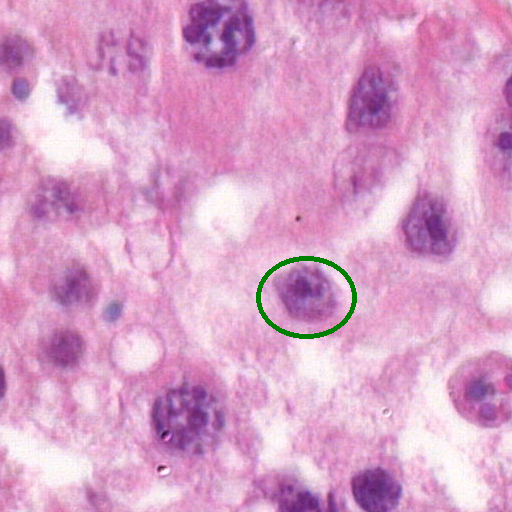

In [8]:
show_annotated_section(annotations[0]['annotations']['70'], slide, 512)

## Creating list of slides

Slicing trough the image with a predefined resolution to create slides.
Collecting annotation information for each slide.

In [9]:
def create_tiles_with_annotation(annotations, slide, tile_size=1024):
    x_dim = slide.level_dimensions[0][0]
    y_dim = slide.level_dimensions[0][1]
    
    tile_annotations = []
    # Moving through image with tiles.
    for x in range(0, x_dim, 1024):
        for y in range(0, y_dim, 1024):
            tile_info = {}
            
            # Top left pixel of tile.
            x_0 = (x, y)
            # Bottom right pixel.
            x_1 = (x + tile_size, y + tile_size)

            # Collect all annotations inside tile.
            tile_anns = []
            # Check if there are annotations inside tile.
            for ann in annotations['annotations']:
                centres = annotations['annotations'][ann]['geometry']['points']

                ann_in_image = False
                for point in centres:
                    x_p, y_p = point
                    # Point inside tile.
                    if x_p < x_1[0] and x_p > x_0[0] and y_p < x_1[1] and y_p > x_0[1]:
                        ann_in_image = True

                if ann_in_image:
                    tile_anns.append(annotations['annotations'][ann])

            
            tile_info['top_left'] = x_0
            tile_info['image_size'] = tile_size
            tile_info['annotations'] = tile_anns
            
            tile_annotations.append(tile_info)
    return tile_annotations

# Statistics

Gather statistics about created slides

In [10]:
def show_tiles_statistics(annotated_tiles):
    tot_count = len(annotated_tiles)
    empty_images = 0
    annotated_images = 0
    max_annotations_in_image = 0
    
    for tile in annotated_tiles:
        if len(tile['annotations']) == 0:
            empty_images += 1
        else:
            annotated_images += 1
            num_annotations = len(tile['annotations'])
            if num_annotations > max_annotations_in_image:
                max_annotations_in_image = num_annotations

    print('Total slides: \t\t{}'.format(tot_count))
    print('Slides not annotated: \t{}'.format(empty_images))
    print("Annotated slides: \t{}".format(annotated_images))
    print("Max annotations: \t{}".format(max_annotations_in_image))


In [11]:
slide_annotated_tiles = create_tiles_with_annotation(annotations[0], slide)
show_tiles_statistics(slide_annotated_tiles)

Total slides: 		70411
Slides not annotated: 	70353
Annotated slides: 	58
Max annotations: 	19


In [12]:
def show_tile_annotations(annotated_tiles, slide, num_images=1, save=False, filename = None):
    """
    Display tiles with annotatied images
    """
    tiles_with_annotations = []

    # Select tiles only with annotations.
    for tile in annotated_tiles:
        if len(tile['annotations']) > 0:
            tiles_with_annotations.append(tile)

    # Add different color for different label.
    # The only key that changes in annotations file is
    # label_color_* that may represent label.
    colors = {
        'label_color 1' : 'blue',
        'label_color 2' : 'green',
        'label_color 3' : 'red',
        'label_color 4' : 'yellow'
    }

    sample = random.sample(tiles_with_annotations, num_images)
    for tile in sample:
        top_left = tile['top_left']

        img = slide.read_region(
            location = (
                top_left[0],
                top_left[1]
            ),
            level = 0,
            size = (tile['image_size'], tile['image_size'])
        )

        for ann in tile['annotations']:
            ann_points = ann['geometry']['points']
            x1, y1 = ann_points[0][0], ann_points[0][1]
            x2, y2 = ann_points[1][0], ann_points[1][1]
            # Drawing points are relative to the top left
            # as the new image top left is (0,0)
            point1 = (
                x1 - top_left[0], 
                y1 - top_left[1]
            )
            point2 = (
                x2 - top_left[0],
                y2 - top_left[1]
            )
            # Pillow draws only if point1 < point2,
            # so that the point1 is upper left and point2 is lower right.
            if point1 > point2:
                #Swap
                point1, point2 = point2, point1
                
            # Color according to label.
            outline_color = 'white'
            for key in ann['user_attrs'].keys():
                if key in colors.keys():
                    outline_color = colors[key]

            # Draw an ellipse over the image
            draw = ImageDraw.Draw(img)
            draw.ellipse(
                [
                    point1,
                    point2
                ],
                width=4,
                outline=outline_color
            )
        
        if save:
            if filename == None:
                filename = "tile_{}_{}.png".format(top_left[0], top_left[1])
            img.save('./samples/' + filename)
        else:
            print("Top_left: {}".format(tile['top_left']))
            print("Slide : {}".format(slide._filename))
            display(img)

Top_left: (115712, 190464)
Slide : ../data/18H14294I.mrxs


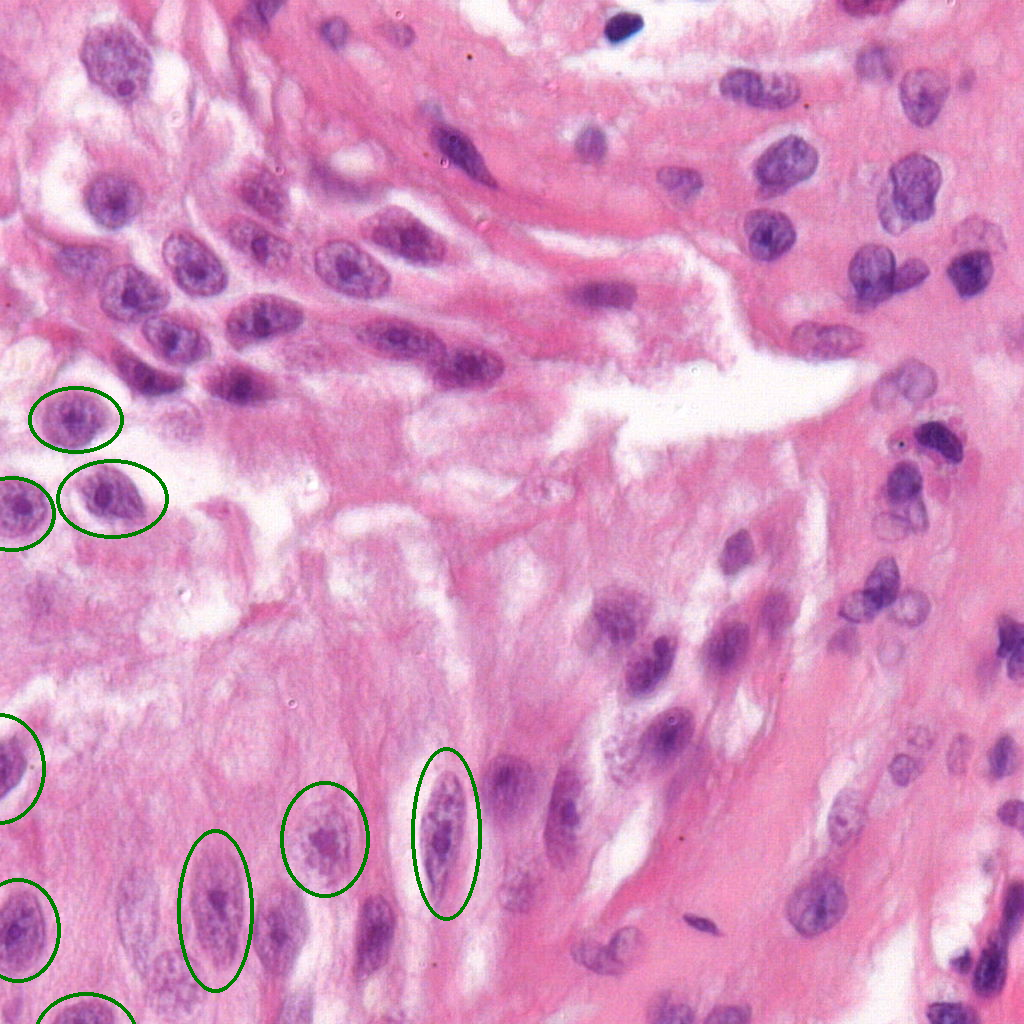

In [13]:
show_tile_annotations(slide_annotated_tiles, slide, num_images=1)

In [14]:
def create_tiles_with_annotation(
    annotations, slide, tile_size=1024, image_dir="", save_images=False
):
    """
    Generates tiles with annotations. Moves above the WSI with selected tile size
    and finds all annotations for selected region.
    ---
    annotations : array
        Annotations of WSI slide.
    slide : OpenSlide
        OpenSlide object of WSI.
    tile_size : int
        Size of the generated image.
    image_dir : str
        Location where to store generated images if image saving is requested.
    save_images : bool
        Switch to enable saving annotated sections of WSI images.
    """

    x_dim = slide.level_dimensions[0][0]
    y_dim = slide.level_dimensions[0][1]
    filename = slide._filename.split("/")[-1].split(".")[0]

    tile_annotations = []

    # Moving through image with tiles.
    for x in range(0, x_dim, tile_size):
        for y in range(0, y_dim, tile_size):
            tile_info = {}

            # Top left pixel of tile.
            x_0 = (x, y)
            # Bottom right pixel.
            x_1 = (x + tile_size, y + tile_size)

            # Collect all annotations inside tile.
            tile_anns = []
            # Check if there are annotations inside tile.
            for ann in annotations["annotations"]:
                centres = annotations["annotations"][ann]["geometry"]["points"]

                ann_in_image = False
                for point in centres:
                    x_p, y_p = point
                    # Point inside tile.
                    if x_p < x_1[0] and x_p > x_0[0] and y_p < x_1[1] and y_p > x_0[1]:
                        ann_in_image = True

                if ann_in_image:
                    tile_anns.append(annotations["annotations"][ann])

            tile_info["top_left"] = x_0
            tile_info["image_size"] = tile_size
            tile_info["annotations"] = tile_anns
            tile_info["filename"] = filename

            tile_annotations.append(tile_info)

    # Save annotated images.
    if save_images:
        if image_dir == "":
            image_dir = "images/"

        if image_dir[-1] != os.path.sep:
            image_dir = image_dir + os.path.sep

        if not os.path.exists(image_dir):
            os.mkdir(image_dir)

        tiles = pd.DataFrame(tile_annotations)
        tiles_with_annotations = tiles[tiles.annotations.str.len() > 0]
        for _, row in tiles_with_annotations.iterrows():
            save_annotated_image(image_dir, slide, row.top_left, row.image_size)

    return tile_annotations

In [15]:
def label_to_category_id(label):
    return {
        'label_color 1' : 1,
        'label_color 2' : 2,
        'label_color 3' : 3,
        'label_color 4' : 4,
        'label_color 5' : 5
    }[label]


In [16]:
def get_annotation_label(annotation):
    available_keys = [
        'label_color 1', 
        'label_color 2',
        'label_color 3',
        'label_color 4',
        'label_color 5'
        ]

    keys = annotation['user_attrs'].keys()
    for key in keys:
        if key in available_keys:
            return key


In [17]:
def get_annotation_area(annotation):
    return annotation['stats']['area_px']

In [18]:
def calculate_bbox(annotation, top_left):
    ann_points = annotation['geometry']['points']
    x1, y1 = ann_points[0][0], ann_points[0][1]
    x2, y2 = ann_points[1][0], ann_points[1][1]
    # Drawing points are relative to the top left
    # as the new image top left is (0,0)
    point1 = (
        x1 - top_left[0], 
        y1 - top_left[1]
    )
    point2 = (
        x2 - top_left[0],
        y2 - top_left[1]
    )

    # Swap if points are flipped. Point1 should be upper left.
    if point1 > point2:
        point1, point2 = point2, point1
    
    width = point2[0] - point1[0]
    height = point2[1] - point1[1]

    return [point1[0], point1[1], width, height]


In [50]:
def get_annotation_filename(annotation):
    return "{}_{}_{}.png".format(
            annotation['filename'], 
            annotation['top_left'][0], 
            annotation['top_left'][1]
    )

In [52]:
def create_COCO_annotations(tiles_with_annotation):
    df = pd.DataFrame(tiles_with_annotation)
    coco = {}

    coco["info"] = {
        "description": "HistoPathology dataset",
        "url": "http://cocodataset.org",
        "version": "1.0",
        "year": 2021,
        "contributor": "Kaarel R",
        "date_created": time.asctime(),
    }

    coco["licenses"] = {}
    coco["images"] = []
    coco["annotations"] = []

    ann_id = 0
    # Iterating trough only annotated images.
    tiles_with_annotations = df[df.annotations.str.len() > 0]
    for id, row in tiles_with_annotations.iterrows():
        im = {
            "license": 0,
            "file_name": get_annotation_filename(row),
            "coco_url": "",
            "height": row.image_size,
            "width": row.image_size,
            "date_captured": "2021-05-8 17:00:00",
            "flickr_url": "",
            "id": id,
        }

        prev_annotation = row.annotations
        for ann in prev_annotation:
            bbox = calculate_bbox(ann, row.top_left)
            poly = ellipse_to_polygon(bbox)
            coco_ann = {
                "id": ann_id,
                "image_id": id,
                "category_id": label_to_category_id(get_annotation_label(ann)),
                "segmentation": poly,
                "area": get_annotation_area(ann),
                "bbox": bbox,
                "iscrowd": 0,
            }
            coco["annotations"].append(coco_ann)
            ann_id += 1

        coco["images"].append(im)

    coco["categories"] = [
        {"supercategory": "cell", "id": 1, "name": "Spermatogonia"},
        {"supercategory": "cell", "id": 2, "name": "Sertoli"},
        {"supercategory": "cell", "id": 3, "name": "Primary spermatocyte"},
        {"supercategory": "cell", "id": 4, "name": "Spermatid"},
        {"supercategory": "cell", "id": 5, "name": "Spermatozoa"},
    ]

    return coco

In [20]:
def ellipse_to_polygon(bbox):
    # Top left pixel.
    x = bbox[0]
    y = bbox[1]

    width = bbox[2]
    height = bbox[3]

    center = (
        (x + width)/2, 
        (y + height)/2
    )

    ell = Ellipse((center[0],center[1]), width, height)
    # Polyon
    poly = np.array(ell.get_path().to_polygons())
    poly = poly.reshape(poly.shape[1], poly.shape[2]) # Reduce first dimension

    # Scale points with widht and height
    poly = poly * [width, height]

    # Convert coordinates to original image
    poly = poly + [center[0], center[1]]
    
    # TODO: if the last point should be the same as first?
    return poly

In [23]:
tiles_with_annotations = create_tiles_with_annotation(annotations[0], slide)

In [53]:
coco = create_COCO_annotations(tiles_with_annotations)

In [54]:
coco.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [55]:
coco['images']

[{'license': 0,
  'file_name': '18H14294I_98304_209920.png',
  'coco_url': '',
  'height': 1024,
  'width': 1024,
  'date_captured': '2021-05-8 17:00:00',
  'flickr_url': '',
  'id': 39277},
 {'license': 0,
  'file_name': '18H14294I_99328_208896.png',
  'coco_url': '',
  'height': 1024,
  'width': 1024,
  'date_captured': '2021-05-8 17:00:00',
  'flickr_url': '',
  'id': 39683},
 {'license': 0,
  'file_name': '18H14294I_100352_208896.png',
  'coco_url': '',
  'height': 1024,
  'width': 1024,
  'date_captured': '2021-05-8 17:00:00',
  'flickr_url': '',
  'id': 40090},
 {'license': 0,
  'file_name': '18H14294I_100352_209920.png',
  'coco_url': '',
  'height': 1024,
  'width': 1024,
  'date_captured': '2021-05-8 17:00:00',
  'flickr_url': '',
  'id': 40091},
 {'license': 0,
  'file_name': '18H14294I_101376_209920.png',
  'coco_url': '',
  'height': 1024,
  'width': 1024,
  'date_captured': '2021-05-8 17:00:00',
  'flickr_url': '',
  'id': 40498},
 {'license': 0,
  'file_name': '18H14294I_